# Machine Learning for the Sensored Internet of Things

<img src="ml-prediction.jpg">

## Who am I
Hank Roark
Data Scientist & Hacker @ H2O.ai

Lecturer in Systems Thinking, University of Illinois at Urbana-Champaign

John Deere, Research, Software Product Development, High Tech Ventures

Lots of time dealing with data off of machines, equipment, satellites, radar, hand sampled, and on.

Geospatial and temporal / time series data almost all from sensors.

Previously at startups and consulting (Red Sky Interactive, Nuforia, NetExplorer, Perot Systems, a few of my own)

Systems Design & Management MIT<br>
Physics Georgia Tech

hank@h2oai.com<br>
@hankroark<br>
https://www.linkedin.com/in/hankroark

## IoT Data Comes From Lots of Places, much of it from sensors

<img src="https://gkapteina.files.wordpress.com/2015/08/br-internet-of-things-ecosystem.jpg">

## The data is going to be huge, so get ready
<img src="http://www8.hp.com/h30458/media2.php/EZINE/April%20infographics/APR_IM_INFOG.jpg?version=349e115e815fac03bd19756911efee13">

## Wow, how big is a brontobyte?
<img src="http://www.intellaegis.com/wp-content/uploads/2015/01/IOT-Explosion.jpg">

## Nah, will the data really be that big?

In [ ]:
#from IPython.display import IFrame
#IFrame('http://www.vrworld.com/2015/05/08/big-data-in-planes-new-pw-gtf-engine-telemetry-to-generate-10gbs/', width=800, height=350)

# This much data will require a fast OODA loop
## Much of these models will then be used in control systems
<img src="http://www.telecom-cloud.net/wp-content/uploads/2015/05/Screen-Shot-2015-05-27-at-3.51.47-PM.png" width=800>

# Use Case on Simulated Sensor Data


## Prognostics
Prognostics is an engineering discipline focused on predicting the time at which a system or a component will no longer perform its intended function.  This lack of performance is most often a failure beyond which the system can no longer be used to meet desired performance. The predicted time then becomes the remaining useful life (RUL), which is an important concept in decision making for contingency mitigation.

https://en.wikipedia.org/wiki/Prognostics


## Machine Learning Prognostics for Turbofan Engine Degradation Dataset

Information about the problem is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/publications/#turbofan and original data is at http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan

The data was originally generated using the Commercial Modular Aero-Propulsion System Simulations (C-MAPPS) system.

The approach used in the turbofan engine degradation dataset was then used in the PHM08 challenge.  Information about other research on the C-MAPSS data is available at  https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2014/phmc_14_063.pdf


## Sometimes the simple things work
"A significant characteristic of the PHM Challenge dataset is that it contains time series and therefore the representation of time or at least how to represent and take account of previous temporal observations is an important consideration. The <b>quickest and
simplest method for representing time is to consider each time
point independently and create a prediction at each time step</b>.
An alternative representation would be to consider using a
phase space embedding representation, in which a sequence of
instances is generated using a fixed length sliding window.
However <b>phase space embedding has the significant drawback
of increasing the number of dimensions proportionally with
each time step represented, giving rise to the problems
associated with the 'curse of dimensionality'</b>. From preliminary
experiments it was found that the prediction performance did
not improve significantly using the embedding space
representation given the increase in computational demands.
Therefore the chosen representation was to predict remaining
life using single time points".

Leto Peel, Member, IEEE (GOLD) " Data Driven Prognostics using a
Kalman Filter Ensemble of Neural Network Models" 2008
international conference on prognostics and health management.

## The approach of treating each time point independently will be used

In [104]:
# some ML
import h2o

# some munging, pre- and post-processing
import numpy as np
import pandas as pd
import pykalman as pyk

# some exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Doing hyper parameter searches only when needed
do_grid_search = False

# Preprocessing

In [105]:
# Input files don't have column names
dependent_var = ['RemainingUsefulLife']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

### Read in the raw files

In [106]:
h2o.init()

H2O cluster uptime:,4 days 22 hours 34 minutes 36 seconds 108 milliseconds
H2O cluster version:,3.3.0.3200
H2O cluster name:,H2ODemo
H2O cluster total nodes:,1
H2O cluster total memory:,192.19 GB
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


In [107]:
train = h2o.upload_file("train_FD001.txt")
test  = h2o.upload_file("test_FD001.txt")
train.set_names(input_file_column_names);
test.set_names(input_file_column_names);


Parse Progress: [##################################################] 100%
Uploaded py95ae0cf9-93a6-41cb-8e2c-63919da3e42d into cluster with 20,631 rows and 26 cols

Parse Progress: [##################################################] 100%
Uploaded pyd871de9a-ee91-4daf-8a92-0256d2dee753 into cluster with 13,096 rows and 26 cols


### Calculate Remaining Useful Life in T-minus notation for the training data
This puts all data on the same basis for supervised training

In [108]:
def add_remaining_useful_life(h2o_frame):
    # Get the total number of cycles for each unit
    grouped_by_unit = h2o_frame.group_by(by=["UnitNumber"])
    max_cycle = grouped_by_unit.max(col="Cycle").get_frame()
    
    # Merge the max cycle back into the original frame
    result_frame = h2o_frame.merge(max_cycle)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_Cycle"] - result_frame["Cycle"]
    result_frame["RemainingUsefulLife"] = remaining_useful_life
    
    # drop the un-needed column
    result_frame = result_frame.drop("max_Cycle")
    return result_frame

train_with_predictor = add_remaining_useful_life(train)

## Exploratory Data Analysis

Look at how the sensor measures evolve over time (first column) as well as how they relate to each other for a subset of the units.


In [109]:
train_pd = train_with_predictor.as_data_frame()

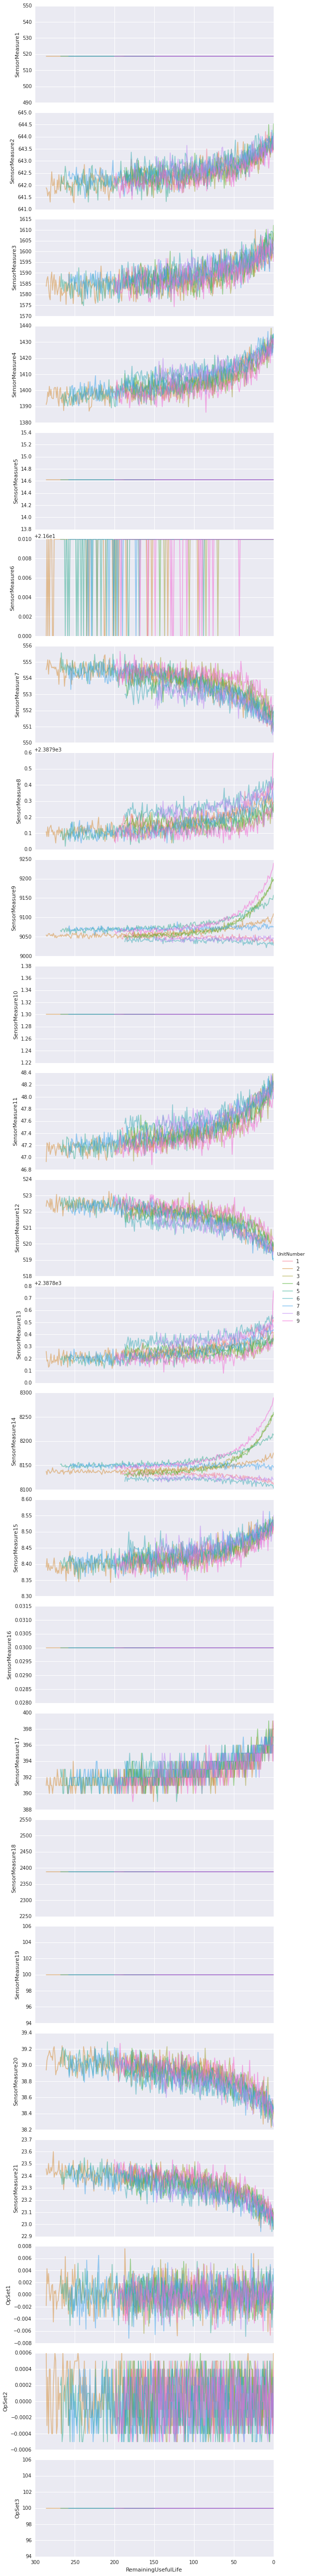

In [110]:
g = sns.PairGrid(data=train_pd.query('UnitNumber < 10') ,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_columns_names + operational_settings_columns_names,
                 hue="UnitNumber", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

Confirms that the operational settings are within one small operational region.

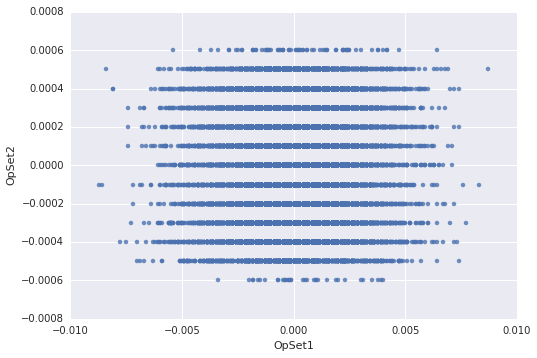

In [111]:
g = sns.regplot(data=train_pd, x="OpSet1", y="OpSet2", fit_reg=False)

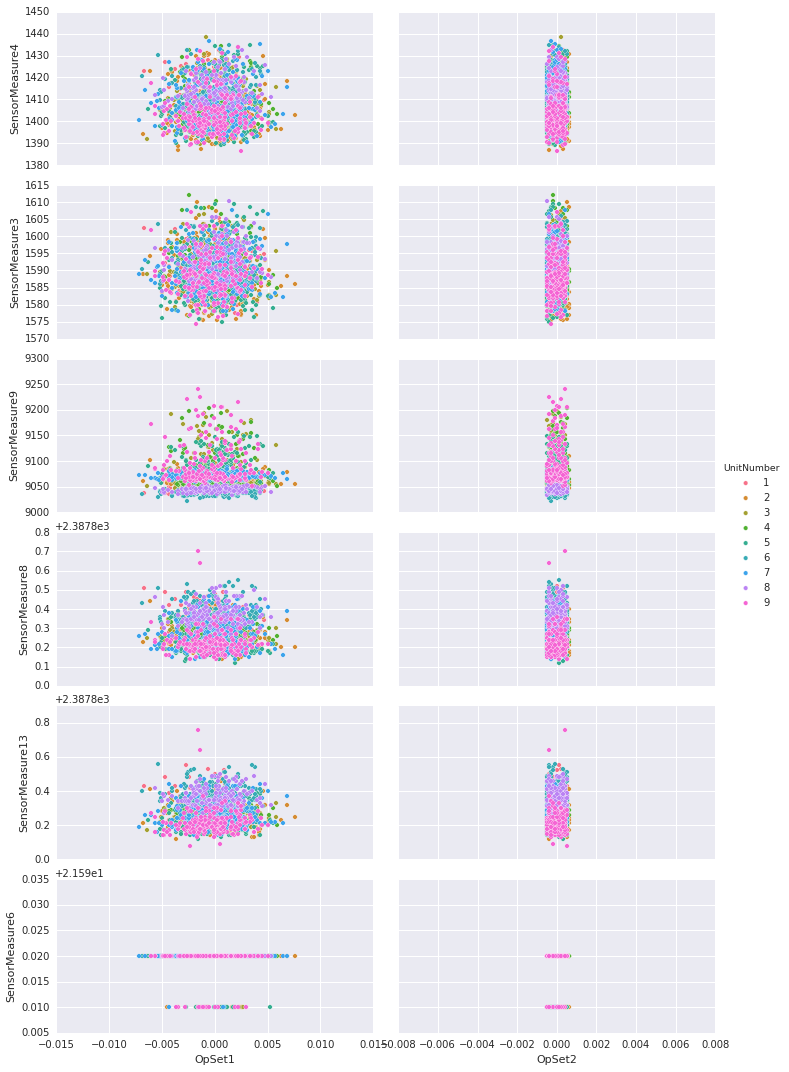

In [112]:
g = sns.pairplot(data=train_pd.query('UnitNumber < 10'),
                 x_vars=["OpSet1","OpSet2"],
                 y_vars=["SensorMeasure4", "SensorMeasure3", "SensorMeasure9", "SensorMeasure8", "SensorMeasure13", "SensorMeasure6"],
                 hue="UnitNumber", aspect=2)


## Feature Selection

These features were selected partially after looking at the graphs above...

But partially because later on thin the ML work certain features produced more predictive models (e.g., including Sensor 6 improved cross validation results) and some things improve results when being dropped (Operational Settings).

In [113]:
independent_vars = ["SensorMeasure"+str(i) for i in [2,3,4,6,7,8,9,11,12,13,14,15,17,20,21]]

# Modeling

### Setup cross validation
Setup a fold column to great cross validation models from 90 units and cross validating on 10 units.  This creates a 10-fold cross validation.  The cross validation models are then used to create an ensemble model for predictions

In [114]:
fold_col = "UnitNumberMod10"
train_with_predictor[fold_col] = train_with_predictor["UnitNumber"] % 10

### Train a series of GLM Models using Grid Search over $\alpha$ and $\lambda$
I like GLMs, they are fast.  But don't deal well with non-linearity.

TODO: Consider some addition feature engineering / transforms (log transforms)

In [115]:
do_grid_search=True
def train_glm(x_cols, y_col, training_frame, fold_col, alpha=0.5, penalty=1e-5):
    return h2o.glm(x=x_cols, y=y_col, training_frame=training_frame, 
                   fold_column=fold_col,family = "gaussian",
                   alpha = alpha, Lambda = penalty,
                   keep_cross_validation_predictions=True )

def grid_search_glm(x_cols, y_col, training_frame, fold_col, alphas = [0,0.5,1], penalties=np.logspace(-4,0,num=5)):
    results = []
    for alpha in alphas:
        for penalty in penalties:
            results.append( train_glm(x_cols, y_col, training_frame=training_frame, 
                                      fold_col=fold_col, alpha=alpha, penalty=penalty) )
    return results

if do_grid_search:
    glm_models = grid_search_glm(independent_vars,dependent_var,
                                 training_frame=train_with_predictor,fold_col=fold_col)
else:
    # this is used to speed up the demonstration by just building the single model previously found
    glm_models = [train_glm(independent_vars,dependent_var,
                            training_frame=train_with_predictor,fold_col=fold_col,
                            alpha=0.,penalty=0.01 )]


glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%

glm Model Build Progress: [#####################################

### Extract the 'best' model

Uses model with lowest score on the cross validation data.  Score was collected for each cycle, because we do not know how many cycles we will see in the test data.

In [116]:
def get_xval_preds(model):
    xval_pred = None
    for xval_pred_info in model._model_json['output']['cross_validation_predictions']:
        single_pred = h2o.get_frame(xval_pred_info['name'])
        if xval_pred is None:
            xval_pred = single_pred["predict"]
        else:
            xval_pred["predict"] = xval_pred["predict"] + single_pred["predict"]
            
    return xval_pred

def sensor_preds(frame):
    frame["predict"] = h2o.ifelse(frame["predict"] < 0., 0., frame["predict"])
    return frame

def append_score(target_frame):
    target_frame["diff"] = target_frame["predict"] - target_frame["RemainingUsefulLife"]
    target_frame["score"] = target_frame.apply(lambda r: h2o.ifelse(r['diff'] < 0,r['diff']/(-10.),r['diff']/13.), axis=1)
    target_frame["score"] = target_frame["score"].expm1()
    target_frame = target_frame.drop("diff")
    return target_frame

def get_median_score(target_frame):
    return target_frame["score"].mean()

def get_val_preds_with_info(model):
    xval_pred = get_xval_preds(model)
    xval_pred = sensor_preds(xval_pred)
    xval_pred = xval_pred.cbind(train_with_predictor["UnitNumber"])
    xval_pred = xval_pred.cbind(train_with_predictor["Cycle"])
    xval_pred = xval_pred.cbind(train_with_predictor["RemainingUsefulLife"])
    xval_pred = append_score(xval_pred)
    return xval_pred

def get_models_preds_scores(models):
    result = []
    for model in models:
        xval_pred = get_val_preds_with_info(model)
        median = get_median_score(xval_pred)
        result.append((model, xval_pred, median))
    return result

def extract_best_model(models):
    bestError = models[0][2]
    result = models[0]
    for model in models:
        if model[2] < bestError:
            bestError = model[2]
            result = model
    return result

In [117]:
glm_models_preds_scores = get_models_preds_scores(glm_models)
best_glm_model = extract_best_model(glm_models_preds_scores)

In [118]:
print "Mean Score: " + str(best_glm_model[2])
best_glm_model[0]

Mean Score: 976465.199283
Model Details
H2ORegressionModel :  Generalized Linear Model
Model Key:  GLM_model_python_1443806419928_585

GLM Model: summary



,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,gaussian,identity,Ridge ( lambda = 0.01 ),15,16,1,pyde78c03e-42f3-4f09-acbf-bdc2c613a3bc




ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1994.80317776
R^2: 0.579542271849
Mean Residual Deviance: 1994.80317776
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 97880908.3648
Residual deviance: 41154784.3604
AIC: 215342.782812

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 2052.82694287
R^2: 0.567312222925
Mean Residual Deviance: 2052.82694287
Null degrees of freedom: 20630
Residual degrees of freedom: 20615
Null deviance: 98171005.0908
Residual deviance: 42351872.6584
AIC: 215934.324169

Scoring History:


,timestamp,duration,iteration,log_likelihood,objective
,2015-10-07 16:04:52,0.000 sec,0,48955702.789,2372.91952833


### Build a series of RF and GBM models using grid search for hyper-parameters


In [119]:
def train_rf(x_cols, y_col, training_frame, fold_column, ntrees, max_depth):
    return h2o.random_forest(x=x_cols, y=y_col, training_frame=training_frame, keep_cross_validation_predictions=True,
                             fold_column=fold_column,ntrees=ntrees, max_depth=max_depth)

def grid_search_rf(x_cols, y_col, training_frame, fold_column, ntrees=[100,300], max_depth=[5,10,15]):
    results = []
    for ntree in ntrees:
        for depth in max_depth:
            print "RF: {ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"}"
            results.append( train_rf(x_cols, y_col, training_frame, fold_column, ntrees=ntree, max_depth=depth) )
    return results

def train_gbm(x_cols, y_col, training_frame, fold_column, ntrees, max_depth, learn_rate):
    return h2o.gbm(x=x_cols, y=y_col, training_frame=training_frame, learn_rate=learn_rate,
                   keep_cross_validation_predictions=True,
                   fold_column=fold_column,ntrees=ntrees, max_depth=max_depth)

def grid_search_gbm(x_cols, y_col, training_frame, fold_column, ntrees=[100,300,1000], max_depth=[1,3,5], learn_rate=[0.1,0.03]):
    results = []
    for ntree in ntrees:
        for depth in max_depth:
            for rate in learn_rate:
                print "GBM: {ntrees: "+str(ntree)+"},{max_depth: "+str(depth)+"},{"+str(rate)+"}"
                results.append( train_gbm(x_cols, y_col, training_frame, fold_column, ntrees=ntree, max_depth=depth, learn_rate=rate) )
    return results

## Start with RF, tends to be easy to tune and deals with noise well

In [120]:
do_grid_search = False
if do_grid_search:
    rf_models = grid_search_rf(independent_vars,dependent_var,
                               training_frame=train_with_predictor,fold_column=fold_col,
                               ntrees=[100,300], max_depth=[5,10,15])
else:
    rf_models = [train_rf(independent_vars,dependent_var,
                          training_frame=train_with_predictor, fold_column=fold_col,
                          ntrees=300, max_depth=10)]


drf Model Build Progress: [##################################################] 100%


In [121]:
rf_models_preds_scores = get_models_preds_scores(rf_models)
best_rf_model = extract_best_model(rf_models_preds_scores)

In [122]:
print "Mean Score: " + str(best_rf_model[2])
best_rf_model[0]

Mean Score: 779504.296744
Model Details
H2ORegressionModel :  Distributed RF
Model Key:  DRF_model_python_1443806419928_611

Model Summary:


,number_of_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,300.0,2950882.0,10.0,10.0,10.0,790.0,907.0,847.12335




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 1702.51037025
R^2: 0.641150740881
Mean Residual Deviance: 1702.51037025

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 1840.34917404
R^2: 0.612097553609
Mean Residual Deviance: 1840.34917404

Scoring History:


,timestamp,duration,number_of_trees,training_MSE,training_deviance
,2015-10-07 16:09:58,2 min 58.449 sec,1.0,2094.48385249,2094.48385249
,2015-10-07 16:09:58,2 min 58.501 sec,2.0,2050.48333982,2050.48333982
,2015-10-07 16:09:58,2 min 58.554 sec,3.0,1987.53368681,1987.53368681
,2015-10-07 16:09:58,2 min 58.608 sec,4.0,1960.35379928,1960.35379928
,2015-10-07 16:09:58,2 min 58.661 sec,5.0,1920.6687969,1920.6687969
---,---,---,---,---,---
,2015-10-07 16:10:02,3 min 2.300 sec,74.0,1713.45926358,1713.45926358
,2015-10-07 16:10:02,3 min 2.355 sec,75.0,1713.57274907,1713.57274907
,2015-10-07 16:10:06,3 min 6.361 sec,151.0,1706.49906074,1706.49906074
,2015-10-07 16:10:10,3 min 10.384 sec,234.0,1704.02532983,1704.02532983



Variable Importances:


variable,relative_importance,scaled_importance,percentage
SensorMeasure11,5223029760.0,1.0,0.3175302389
SensorMeasure4,2937435136.0,0.562400612475,0.178579200837
SensorMeasure12,2077999232.0,0.397853224562,0.126330429442
SensorMeasure7,1559000832.0,0.298485917875,0.094778304811
SensorMeasure9,1168808320.0,0.22377975499,0.071056839063
SensorMeasure15,999553728.0,0.191374312215,0.060767131077
SensorMeasure14,727452608.0,0.139277898351,0.044224944337
SensorMeasure20,658346624.0,0.126046883562,0.04002369705
SensorMeasure21,303795776.0,0.0581646649473,0.0184690399562
SensorMeasure2,239321232.0,0.0458203845272,0.0145493576454


## Now GBM.  I really like GBMs.  
Sometimes can memorize noise, so be careful of overfitting.

GBMs have lots of parameters, so computation can take time.  I tend to fix the number of trees and tune the other parameters around it.  For time, I settled on 300, but 1000 is my normal amount.

Don't be afraid of deep interactions with GBMs.  Common recommendation is to be shrubs (shallow trees), but I find that deep trees often work (but not this time).

In [123]:
if do_grid_search:
    gbm_models = grid_search_gbm(independent_vars,dependent_var,
                                 training_frame=train_with_predictor,fold_column=fold_col, 
                                 ntrees=[300], max_depth=[5,7,10], learn_rate=[0.03,0.02,0.01])
else:
    gbm_models = [train_gbm(independent_vars,dependent_var,
                            training_frame=train_with_predictor,
                            fold_column=fold_col,
                            ntrees=300, max_depth=7, learn_rate=0.02)]


gbm Model Build Progress: [##################################################] 100%


In [124]:
gbm_models_preds_scores = get_models_preds_scores(gbm_models)
best_gbm_model = extract_best_model(gbm_models_preds_scores)

In [126]:
print "Mean Score: " + str(best_gbm_model[2])
print best_gbm_model[0].params['learn_rate']['actual']
best_gbm_model[0]

Mean Score: 964799.559152
0.02
Model Details
H2ORegressionModel :  Gradient Boosting Machine
Model Key:  GBM_model_python_1443806419928_613

Model Summary:


,number_of_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,300.0,311539.0,7.0,7.0,7.0,18.0,128.0,84.29




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1325.68179434
R^2: 0.720577367375
Mean Residual Deviance: 1325.68179434

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1867.26013946
R^2: 0.606425353209
Mean Residual Deviance: 1867.26013946

Scoring History:


,timestamp,duration,number_of_trees,training_MSE,training_deviance
,2015-10-07 16:15:07,4 min 9.480 sec,1.0,4627.55424133,4627.55424133
,2015-10-07 16:15:07,4 min 9.541 sec,2.0,4515.33818274,4515.33818274
,2015-10-07 16:15:07,4 min 9.602 sec,3.0,4407.53466217,4407.53466217
,2015-10-07 16:15:07,4 min 9.662 sec,4.0,4303.8434769,4303.8434769
,2015-10-07 16:15:07,4 min 9.723 sec,5.0,4204.20233291,4204.20233291
---,---,---,---,---,---
,2015-10-07 16:15:11,4 min 13.382 sec,64.0,1850.89142135,1850.89142135
,2015-10-07 16:15:15,4 min 17.432 sec,132.0,1491.95645107,1491.95645107
,2015-10-07 16:15:19,4 min 21.444 sec,201.0,1399.5384212,1399.5384212
,2015-10-07 16:15:23,4 min 25.498 sec,272.0,1341.90567787,1341.90567787



Variable Importances:


variable,relative_importance,scaled_importance,percentage
SensorMeasure11,846259136.0,1.0,0.475044981982
SensorMeasure4,264703056.0,0.312791962579,0.148590252227
SensorMeasure9,231212768.0,0.273217455699,0.12979058132
SensorMeasure12,91932992.0,0.108634563681,0.0516063043462
SensorMeasure7,77293488.0,0.0913354842647,0.0433884634768
SensorMeasure14,60392960.0,0.0713646180359,0.033901403689
SensorMeasure15,39442560.0,0.0466081349342,0.02214096062
SensorMeasure20,33328248.0,0.0393830288882,0.0187087102486
SensorMeasure21,30743350.0,0.0363285295156,0.0172576856491
SensorMeasure13,25834114.0,0.0305274270032,0.0145019010107


## Deep Learning

Lots of opportunity here.  Lots of reports of multi-layer feed forward neural network doing well.  See http://www.ijens.org/103706-5252%20IJET-IJENS.pdf for an example. 

DL has lots of hyperparameters to search over, so instead of doing a grid search over 65898000 models, we will do a random hyperparameter search and see if hope get lucky.

In [ ]:
# 1, 2, or 3 layers
# 10-100 neurons per hidden layer, in 10 neuron increments, per layer
# 3 activation function options
# 4 input drop out ratios options
# 6 hidden layer drop out ratios options, per layer
# 5 l1 regularization options
# 5 l2 regularization options
sum( [ 10**layers * 3 * 4 * 6**layers * 5 * 5 for layers in [1,2,3] ] )

In [ ]:
activation_options = ["RectifierWithDropout","TanhWithDropout","MaxoutWithDropout"]
dl_models = []
for i in range(0,30):  # build 30 models
    print i
    number_of_layers = np.random.randint(1,4)  # 1 to 3 layers
    hidden = [np.random.randint(10,101) for i in range(0,number_of_layers)]
    activation = activation_options[np.random.randint(len(activation_options))]
    input_dropout_ratio = np.random.uniform(0.0, 0.3)
    hidden_dropout_ratios = [np.random.uniform(0.0,0.5) for i in range(0,number_of_layers)]
    l1 = 10**np.random.randint(-10,-1)
    l2 = 10**np.random.randint(-10,-1)
    next_model = h2o.deeplearning(x=independent_vars, y=dependent_var,
                                  training_frame=train_with_predictor, fold_column=fold_col,
                                  keep_cross_validation_predictions=True,
                                  hidden=hidden, activation=activation,
                                  l1=l1, l2=l2,
                                  input_dropout_ratio = input_dropout_ratio, hidden_dropout_ratios=hidden_dropout_ratios,
                                  single_node_mode=True, reproducible=True, force_load_balance=True,
                                  epochs=100)
    dl_models.append(next_model)

In [ ]:
dl_models_preds_scores = get_models_preds_scores(dl_models)
best_dl_model = extract_best_model(dl_models_preds_scores)

In [ ]:
print "Median Score: " + str(best_dl_model[2])
best_dl_model

## Model Selection

put in here something about each model, and some comments about each model




# Best models are GBM followed closely by RF

### Exploratory model analysis

See how well the models do predicting on the training holdout set.  Also, we can see how the various models have bias and progress overtime.



In [127]:
all_xval_preds = best_glm_model[1]
all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_glm")
all_xval_preds = all_xval_preds.cbind(best_rf_model[1]["predict"])
all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_rf")
all_xval_preds = all_xval_preds.cbind(best_gbm_model[1]["predict"])
all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_gbm")
#all_xval_preds = all_xval_preds.cbind(best_dl_model[1]["predict"])
#all_xval_preds = all_xval_preds.set_name(all_xval_preds._find_idx("predict"),"predict_dl")
all_xval_preds = all_xval_preds.drop("score")

### Plot actual remaining useful life vs predicted remaining useful life

Ideally all points would be on the diagonal, indication prediction from data matched exactly the actual.

Also, it is important that the prediction gets more accurate the closer it gets to no useful life remaining.

Looking at a sample of a couple units.

Moved predictions from H2O to Python Pandas for plotting using Seaborn.

In [128]:
scored_df = all_xval_preds.as_data_frame(use_pandas=True)

In [129]:
a = pd.melt(scored_df, id_vars=['UnitNumber', 'Cycle'])

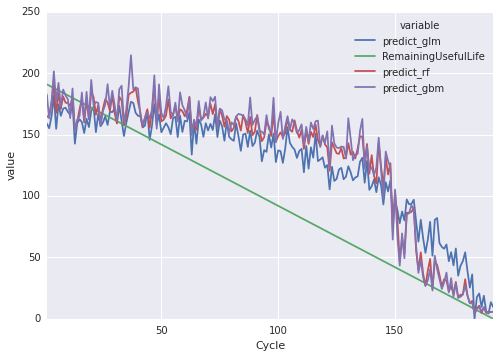

In [130]:
sns.tsplot(data=a[a.UnitNumber == 1], time='Cycle', unit='UnitNumber', condition='variable', value='value',
              err_style=None);

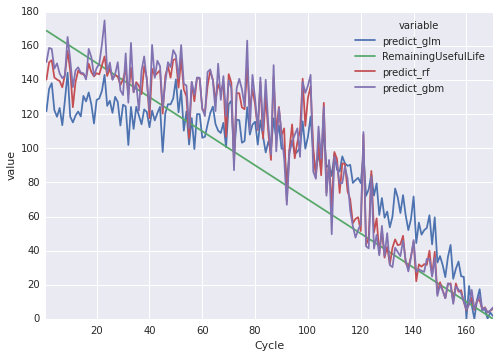

In [131]:
sns.tsplot(data=a[a.UnitNumber == 12], time='Cycle', unit='UnitNumber', condition='variable', value='value',
              err_style=None);

# Model prediction and ensembling

### Ensembling using Kalman filter
Kalman filters use the prior belief about the state of a system, and ensembles measurement of the next measured state and model of how the system evolves from prior state (physics!) to make an improved estimate of the current system state.  In the absense of having the 'physics' and knowledge about the sensors, here we estimate the parameters for the Kalman filter from prior knowledge (the MSE of the models, that each cycle results in a decrease in RUL of 1).

A visual introduction to Kalman filters is available at http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ .  A great hackers introduction to Kalman and Bayseian filters is at  https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python .

<img src="cycle.png">

The hypothesis is that the state of the systems under consideration evolves in this time series manner and the predictions are a non-linear mapping from input space to RUL space.  This is applied repeatedly to each Unit, in both the training and test set.

Again, deciding to do filtering was based on feedback from the models that are later in the notebook as well as a belief in the dynamics of the system under consideration.  Models using Kalman filtering produced better predictive performance than using raw data ( marginally better, so need to decide if complexity / computation is beneficial).  Other filters could be considered but were not.  

H2O now has Discrete Cosine Transforms (DCT) so those can be applied to data at scale in a distributed, in memory environment:  https://0xdata.atlassian.net/browse/PUBDEV-1865.  Also, see SciPy's signal and interpolation packages.

(image courtesy of http://www.codeproject.com/Articles/865935/Object-Tracking-Kalman-Filter-with-Ease)

In [142]:
models_for_pred = [best_gbm_model[0], best_rf_model[0]]
# models_for_pred = [best_gbm_model[0]]+best_gbm_model[0].xvals
preds = [ sensor_preds(model.predict(test)) for model in models_for_pred ]
index = test[["UnitNumber","Cycle"]]
for i,pred in enumerate(preds):
    if i == 0:
        predictions = index.cbind(preds[i])
    else:
        predictions = predictions.cbind(preds[i])

predictions_df = predictions.as_data_frame()

In [143]:
# state is represented as [RUL, -1]
n_dim_state=2
n_dim_obs=len(preds)
a_transition_matrix = np.array([[1,1],[0,1]])
r_observation_covariance = np.diag( [ model.mse() for model in models_for_pred ] )
h_observation_matrices = np.array([[1,0] for _ in models_for_pred])

In [144]:
final_ensembled_preds = {}
pred_cols = [ name for name in predictions_df.columns if "predict" in name]
for unit in predictions_df.UnitNumber.unique():
#for unit in [1]:
    preds_for_unit = predictions_df[ predictions_df.UnitNumber == unit ]
    observations = preds_for_unit.as_matrix(pred_cols)
    initial_state_mean = np.array( [np.mean(observations[0]),-1] )
    kf = pyk.KalmanFilter(transition_matrices=a_transition_matrix,\
                          initial_state_mean=initial_state_mean,\
                          observation_covariance=r_observation_covariance,\
                          observation_matrices=h_observation_matrices,\
                          n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
    mean,_ = kf.filter(observations)
    final_ensembled_preds[unit] = mean

Load up the actual Remaining Useful Life information.

In [145]:
final_preds = { k:final_ensembled_preds[k][-1][0] for k in final_ensembled_preds.keys() }

Add the prediction to the actual data frame, and use the scoring used in the PHMO8 competition (more penality for predicting more useful life than there is actual).

In [146]:
final_preds_df = pd.DataFrame.from_dict(final_preds,orient='index')
final_preds_df.columns = ['predicted']

In [151]:
actual_RUL = pd.read_csv("RUL_FD001.txt",header=None,names=["actual"])
actual_RUL.index = actual_RUL.index+1
actual_preds = actual_RUL.join(final_preds_df)

def score(x):
    diff = x.predicted-x.actual
    result = np.expm1(diff/-10.) if diff < 0. else np.expm1(diff/13.)
    return result

actual_preds["score"] = actual_preds.apply(score, axis=1)
sum(actual_preds.score)                        

3783.979312614249

# This is the final score using PHM08 method of scoring.

This would have been a top 10 score: between 6th and 7th place.

Sensor 6 moved this up from being between 18th and 19th place.

I completed this analysis is about 2 days of part-time work.   Economics would need to dictate if it needs to be improved.

I'd expect this score to improve with more data.  This was a small dataset, so more observations would likely help the learning.

### Finally look at the actual remaining useful life and compare to predicted

Some things that should ideally would be true:
- As RUL gets closer to zero, the prediction gets closer to actual
- More points below line than above (need to work on this)

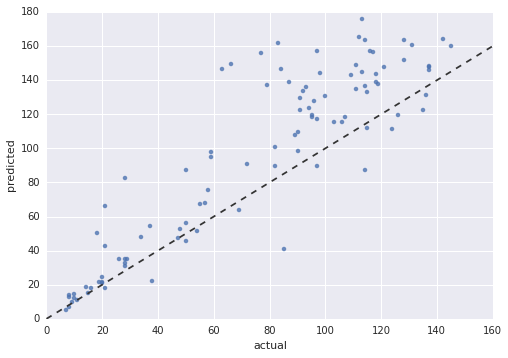

In [166]:
g = sns.regplot("actual", "predicted", data=actual_preds, fit_reg=False)
g.set(xlim=(0, 160), ylim=(0, 180));
g.axes.plot((0, 160), (0, 160), c=".2", ls="--");

## Learned model for scoring

In [161]:
for model in models_for_pred:
    h2o.download_pojo(model, path="/home/ec2-user/python-examples/cmapdata/models", get_jar=True)

# Key take aways

## Some sort of signal processing is usually helpful, but can introduce bias

### - Smoothers, filters, frequency domain, interpolation, LOWESS, ... , feature engineering
### - Knowing a little about the physics of the system may be helpful here

## Validation strategy is important

### - Easy to memorize due to autocorrelation

## Sometimes the simplest things work

### - Treat each observation independently; Use time, location, as data elements

## Uncertainty is the name of the game

### - Methods that will report out probabilities are often required (not shown here)

## The data can be big, get ready, it'll be a great ride

<img src="h2oworldpostcardfrontwithurl.png">
<center></center>

<hr>
hank@h2oai.com<br>
@hankroark<br>
https://www.linkedin.com/in/hankroark